In [1]:
from altaipony.lcio import from_mast, from_path
from altaipony.flarelc import FlareLightCurve
from altaipony.altai import find_iterative_median
from lightkurve import search_targetpixelfile

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

import copy

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/importlib/_bootstrap_external.py:426: ImportWarning: Not importing directory /home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/bokeh/resources.py:107: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/bokeh/_sri.json' mode='r' encoding='UTF-8'>
  _SRI_HASHES = json.load(open(join(ROOT_DIR, "_sri.json")))
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:

from collections import defaultdict

import astropy.units as u

from scipy.interpolate import UnivariateSpline
from scipy import optimize
from scipy.fftpack import fft

from altaipony.altai import find_iterative_median
from altaipony.utils import sigma_clip

import matplotlib.pyplot as plt

def custom_detrending(flc):
    """Wrapper"""
    f = flc.flux[np.isfinite(flc.flux)]

    if np.abs(f[0]-f[-1])/np.median(f) > .2:
        print("Do a coarse spline interpolation to remove trends.")
        flc = fit_spline(flc, spline_coarseness=12)
        flc.flux[:] = flc.detrended_flux[:]

    # Iteratively remove fast sines with Periods of 0.1 to 2 day periods (the very fast rotators)
    print("Remove fast rotation")
    flc = iteratively_remove_sines(flc)
    flc.flux[:] = flc.detrended_flux[:]

    # remove some rolling medians on a 10 hours time scale
    print("Remove rolling median.")
    flc.flux[:] = flc.flux - pd.Series(flc.flux).rolling(300, center=True).median() + np.nanmedian(flc.flux)#15h

    # Determine the window length for the SavGol filter for each continuous observation gap
    print("Find iterative median.")
    flc = find_iterative_median(flc)
    w = search_gaps_for_window_length(flc)
    flc = flc[np.isfinite(flc.flux)]

    # Use lightkurve's SavGol filter while padding outliers with 25 data points around the outliers/flare candidates
    print("Use savgol filter.")
    flc = flc.detrend("savgol", window_length=w, pad=25)
    flc.flux[:] = flc.detrended_flux[:]

    # After filtering, always use a 2.5 hour window to remove the remaining
    flcd = flc.detrend("savgol", window_length=75, pad=25)

    # Determine the noise properties with a rolling std, padding masked outliers/candidates
    print("Determine improved uncertainty estimate.")
    flcd = refine_detrended_flux_err(flcd, mask_pos_outliers_sigma=1.5,
                                     std_rolling_window_length=15, pad=25)
    return flcd


def refine_detrended_flux_err(flcd, mask_pos_outliers_sigma=2.5, 
                              std_rolling_window_length=15, pad=25):
    """Attempt to recover a good estimate of the ligh curve noise.
    Start out from a simple standard deviation of the flux.
    Then filter out outliers above `mask_pos_outliers_sigma`.
    Apply rolling window standard deviation on the filtered array.
    Calculate a mean standard deviation from the result.
    Fill in this mean into the masked values.

    Parameters:
    -----------
    flcd : de-trended FlareLightCurve

    mask_pos_outliers_sigma : float
        sigma value above which to mask positive outliers
    std_rolling_window_length : int
        rolling window length for standard deviation calculation
    pad : int
        How many values to pad-mask around positive outliers.

    Return:
    --------
    FlareLightCurve with refined `detrended_flux_err` attribute.

    """

    # start with a first approximation to std
    flcd.detrended_flux_err[:] =  np.nanstd(flcd.detrended_flux)

    # and refine it:
    flcd = find_iterative_median(flcd)

    filtered = copy.deepcopy(flcd.detrended_flux)

    # mask strong positive outliers so that they don't add to std
    filtered[flcd.detrended_flux - flcd.it_med > mask_pos_outliers_sigma * flcd.detrended_flux_err] = np.nan

    # apply rolling window std
    flcd.detrended_flux_err[:] = pd.Series(filtered).rolling(std_rolling_window_length, min_periods=1).std()

    # set std to mean value if calculation fails to inf
    meanstd = np.nanmean(flcd.detrended_flux_err)

    # pad the excluded values not to create spikes of high error around flares
    isin = np.invert(np.isfinite(flcd.detrended_flux_err))
    x = np.where(isin)[0]
    for i in range(-pad, pad+1):
        y = x + i
        y[np.where(y > len(isin) - 1)] = len(isin) - 1
        isin[y] = True

    x = np.where(isin)[0]
    flcd.detrended_flux_err[x] = meanstd

    return flcd


def search_gaps_for_window_length(flc):
    """Search continuous light curve chunks for
    appropriate window_length to apply to
    SavGol filter.

    Parameters:
    ------------
    flc : FlareLightCurve

    Return:
    -------
    list of odd ints
    """
    flc = flc[np.where(np.isfinite(flc.flux))]
    flc = flc.find_gaps()
    wls = []
    for le,ri in flc.gaps:
        wls.append(select_window_length(flc.flux[le:ri]))

    return wls


def select_window_length(flux):
    """Performs an FFT and defines a window
    length that is smaller than the most prominent
    frequency.

    Parameters:
    -----------
    flux : array

    Return:
    --------
    odd int
    """
    #normalize flux and FFT it:
    yf = fft(flux/np.nanmean(flux)-1.)

    maxfreq = len(yf) // 5
    minfreq = 1

    # choose window length
    w = np.rint(len(yf) / (minfreq + np.argmax(yf[minfreq:maxfreq])) / 3)

    # w must be odd
    if w%2==0:
        w += 1

    # if w is too large don't do it at all
    if w > len(yf) // 2:
        return None
    else:
        return int(max(w, 75))


def fit_spline(flc, spline_coarseness=12, spline_order=3):
    """Do a spline fit on a coarse sampling of data points.

    Parameters:
    ------------
    flc : FlareLightCurve

    spline_coarseness : int
        Do not spline fit every data point but use the
        average value of spline_coarseness hours
    spline_order : int
        order of spline fit

    Return:
    --------
    FlareLightCurve with new flux attribute
    """
    flc = flc[np.where(np.isfinite(flc.flux))]
    flcp = copy.deepcopy(flc)

    flcp = flcp.find_gaps()
    flux_med = np.nanmedian(flcp.flux)
    n = int(np.rint(spline_coarseness/ 24 / (flcp.time[1] - flcp.time[0])))
    k = spline_order
    #do a first round
    for le, ri in flcp.gaps:

        rip = flcp.flux[le:ri].shape[0] + le
        t, f = np.zeros((rip - le)//n+2), np.zeros((rip - le)//n+2)
        t[1:-1] = np.mean(flcp.time[le:rip - (rip - le)%n].reshape((rip - le)//n, n), axis=1)
        f[1:-1] =  np.median(flcp.flux[le:rip - (rip - le)%n].reshape((rip - le)//n, n), axis=1)
        t[0], t[-1] = flcp.time[le], flcp.time[rip-1]
        f[0], f[-1] = flcp.flux[le], flcp.flux[rip-1]
        p3 = UnivariateSpline(t, f, k=k)
        flcp.detrended_flux[le:ri] = flcp.flux[le:ri] - p3(flcp.time[le:ri]) + flux_med



    return flcp


def iteratively_remove_sines(flcd, freq_unit=1/u.day,
                             maximum_frequency=10,
                             minimum_frequency=0.5):
    def cosine(x, a, b, c, d):
        return a * np.cos(b * x + c) + d

    snr = 9

    flct = copy.deepcopy(flcd)
    for le, ri in flct.find_gaps().gaps:
        flc = copy.deepcopy(flct[le:ri])
        flc = find_iterative_median(flc)
        pg = flc.remove_nans().to_periodogram(freq_unit=freq_unit,
                                          maximum_frequency=maximum_frequency,
                                          minimum_frequency=minimum_frequency)
        snr = pg.flatten().max_power
    #    print("Found peak in periodogram at ", pg.frequency_at_max_power)
    #    print("SNR at ", snr)
        i = 0
        while (snr > 8) & (i < 10):
            pg = flc.remove_nans().to_periodogram(freq_unit=freq_unit,
                                                  maximum_frequency=maximum_frequency,
                                                  minimum_frequency=minimum_frequency)

            cond = np.invert(np.isnan(flc.time)) & np.invert(np.isnan(flc.flux))
            p, p_cov = optimize.curve_fit(cosine, flc.time[cond], flc.flux[cond],
                                          p0=[np.nanstd(flc.flux),
                                          2*np.pi*pg.frequency_at_max_power.value,
                                          0, np.nanmean(flc.flux)])
            flc.flux = np.nanmean(flc.flux) + flc.flux-cosine(flc.time, p[0], p[1], p[2], p[3])
            print(snr)
            snr = pg.flatten().max_power
            print(snr)
            i += 1

        flcd.detrended_flux[le:ri] = flc.flux
    return flcd


In [3]:
def refine_detrended_flux_err(flcd, mask_pos_outliers_sigma=2.5, 
                              std_rolling_window_length=15, pad=25):
    """Attempt to recover a good estimate of the ligh curve noise.
    Start out from a simple standard deviation of the flux.
    Then filter out outliers above `mask_pos_outliers_sigma`.
    Apply rolling window standard deviation on the filtered array.
    Calculate a mean standard deviation from the result.
    Fill in this mean into the masked values.
    
    Parameters:
    -----------
    flcd : de-trended FlareLightCurve
    
    mask_pos_outliers_sigma : float
        sigma value above which to mask positive outliers
    std_rolling_window_length : int
        rolling window length for standard deviation calculation
    pad : int
        How many values to pad-mask around positive outliers.
    
    Return:
    --------
    FlareLightCurve with refined `detrended_flux_err` attribute.
    
    """
    
    # start with a first approximation to std
    flcd.detrended_flux_err[:] =  np.nanstd(flcd.detrended_flux)
    
    # and refine it:
    flcd = find_iterative_median(flcd)
    
    filtered = copy.deepcopy(flcd.detrended_flux)
    
    # mask strong positive outliers so that they don't add to std
    filtered[flcd.detrended_flux - flcd.it_med > mask_pos_outliers_sigma * flcd.detrended_flux_err] = np.nan
    
    # apply rolling window std
    flcd.detrended_flux_err[:] = pd.Series(filtered).rolling(std_rolling_window_length, min_periods=1).std()
  
    # set std to mean value if calculation fails to inf
    meanstd = np.nanmean(flcd.detrended_flux_err)
    
    # pad the excluded values not to create spikes of high error around flares
    isin = np.invert(np.isfinite(flcd.detrended_flux_err))
    x = np.where(isin)[0]
    for i in range(-pad, pad+1):
        y = x + i
        y[np.where(y > len(isin) - 1)] = len(isin) - 1
        isin[y] = True
            
    x = np.where(isin)[0]
    flcd.detrended_flux_err[x] = meanstd
 
    return flcd

In [13]:
ID = 211412192
C = 5
flc = from_mast(f"EPIC {ID}", mission="K2", mode="TPF", c=C)

6% (217/3663) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
6% (217/3663) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


(2320.0, 2330.0)

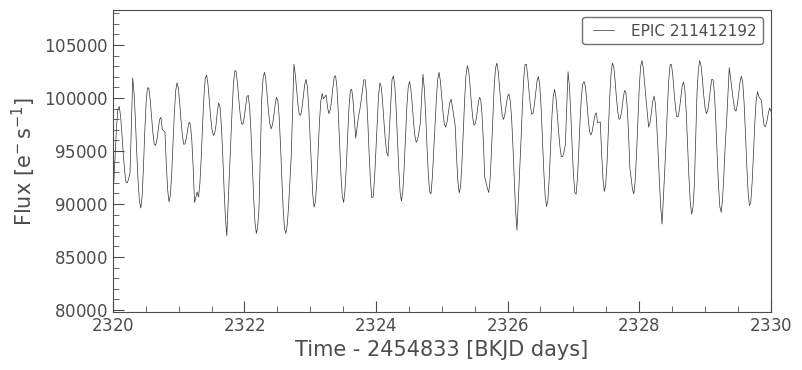

In [15]:
flc.plot()
plt.xlim(2320,2330)

In [ ]:
flc.flux_err[:] = 250.
flc.flux_err

In [42]:
flcd = flc.detrend("k2sc", de_niter=200, splits=[2344], ls_min_period=0.01)

Starting initial outlier detection at 3sigma.
iteration 1 at normalized median flux1.00000 \pm 0.02746
iteration 2 at normalized median flux1.00018 \pm 0.02724
iteration 3 at normalized median flux1.00021 \pm 0.02717
  Flagged 21 ( 0.6%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =    0.22 (fap 0.0000e+00 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE


KeyboardInterrupt: 

In [17]:
flcd = flcd.find_flares()
flcd.flares

Found 169 candidate(s) in the (0,3446) gap.


,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,total_n_valid_data_points
0,10,22,107562,107574,2306.815360,2307.060547,585.088512,0.512750,0.043903,3446.0
1,32,45,107584,107598,2307.264869,2307.550920,661.833381,0.539935,0.044891,3446.0
2,52,64,107605,107617,2307.693945,2307.939132,503.439324,0.503762,0.039421,3446.0
3,76,85,107629,107638,2308.184318,2308.368208,348.797139,0.457085,0.032541,3446.0
4,96,106,107650,107660,2308.613394,2308.817716,364.246756,0.466799,0.032909,3446.0
...,...,...,...,...,...,...,...,...,...,...
164,3346,3357,111107,111118,2379.246063,2379.470812,453.583124,0.499370,0.037712,3446.0
165,3366,3375,111128,111138,2379.675130,2379.879449,483.753684,0.501747,0.041714,3446.0
166,3386,3397,111150,111162,2380.124630,2380.369812,515.706867,0.498193,0.042083,3446.0
167,3406,3417,111171,111183,2380.553699,2380.798881,501.453647,0.538023,0.038111,3446.0


In [34]:
flcr = from_path(f"{ID}_5.fits", mode="AltaiPony", mission="K2")

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/lcio.py:139: ResourceWarning: unclosed file <_io.FileIO name='211412192_5.fits' mode='rb' closefd=True>
  return _from_path_AltaiPony(path)


In [ ]:
flcr2 = refine_detrended_flux_err(flcr)

(2320.0, 2345.0)

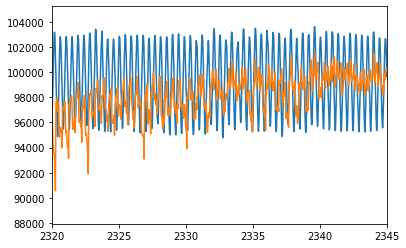

In [41]:
#plt.plot(flcr2.time, flcr2.detrended_flux_err,)
plt.plot(flcr.time, flcr.detrended_flux,)
plt.plot(flcd2.time, flcd2.detrended_flux,)
# plt.ylim(6250,6400)
plt.xlim(2320,2345)

In [43]:
flcd2 = copy.deepcopy(flcr)

flcd2 = custom_detrending(flcd2)

Remove fast rotation
18.263483878584477
18.263483878584477
18.263483878584477
8.168377220662817
8.168377220662817
9.11853766446924
9.11853766446924
9.280644157655795
9.280644157655795
3.7225228656195486
Remove rolling median.
Find iterative median.
Use savgol filter.
Determine improved uncertainty estimate.


(88000.0, 120000.0)

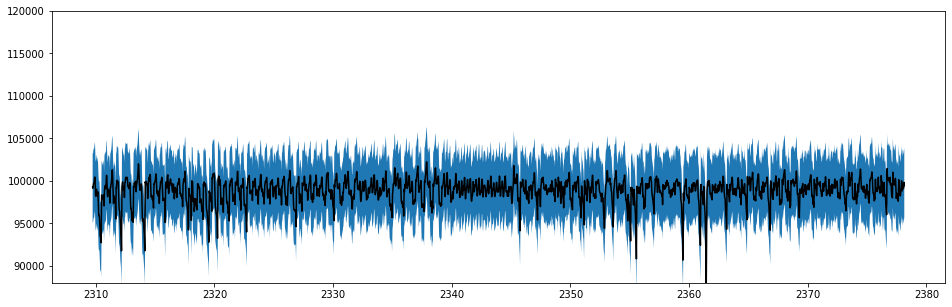

Uncaught exception GET /autoload.js?bokeh-autoload-element=1005&bokeh-absolute-url=http://localhost:42907&resources=none (127.0.0.1)
HTTPServerRequest(protocol='http', host='localhost:42907', method='GET', uri='/autoload.js?bokeh-autoload-element=1005&bokeh-absolute-url=http://localhost:42907&resources=none', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/tornado/web.py", line 1703, in _execute
    result = await result
  File "/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/bokeh/server/views/autoload_js_handler.py", line 60, in get
    session = await self.get_session()
  File "/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/bokeh/server/views/session_handler.py", line 120, in get_session
    session = await self.application_context.create_session_if_needed(session_id, self.request, token)
  File "/home/ekater

In [56]:
plt.figure(figsize=(16,5))
plt.plot(flcd2.time, flcd2.detrended_flux,c="k")
plt.fill_between(x=flcd2.time, y1=flcd2.detrended_flux-5*np.median(flcd2.detrended_flux_err),
                y2=flcd2.detrended_flux + 5*np.median(flcd2.detrended_flux_err))
#plt.xlim(2320,2325)
plt.ylim(88000,120000)

In [46]:
flcd2.detrended_flux_err

array([946.42705068, 946.42705068, 946.42705068, ..., 946.42705068,
       946.42705068, 946.42705068])

In [18]:
flcd.to_fits(f"{ID}_5.fits")

Did not save pixel_flux because fits files only accept 1D arrays.
Did not save pixel_flux_err because fits files only accept 1D arrays.
Did not save pipeline_mask because fits files only accept 1D arrays.


In [ ]:
plt.plot(flcd.time, flcd.detrended_flux)
#plt.xlim(3318, 3321)
#plt.xlim(3284, 3290)

In [ ]:
from astropy.io import fits

In [ ]:
hdu = fits.open("hlsp_k2sc_k2_llc_211398269-c05_kepler_v2_lc.fits")


In [ ]:
data = hdu[1].data
flck = FlareLightCurve(time=data.time, detrended_flux =data.flux)

In [ ]:
hdu[1].header

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(flck.time, flck.detrended_flux)

In [2]:
ID = 212009190
C=18
tpf = search_targetpixelfile("EPIC {}".format(ID), campaign=C).download()


Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/K2/ktwo212009190-c18_lc/ktwo212009190-c18_lpd-targ.fits.gz with expected size 2392157.
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


In [4]:

tpf.interact()


INFO:bokeh.server.server:Starting Bokeh server version 2.0.0 (running on Tornado 6.0.4)
INFO:bokeh.server.tornado:User authentication hooks NOT provided (default user enabled)


Uncaught exception GET /autoload.js?bokeh-autoload-element=1005&bokeh-absolute-url=http://localhost:42907&resources=none (127.0.0.1)
HTTPServerRequest(protocol='http', host='localhost:42907', method='GET', uri='/autoload.js?bokeh-autoload-element=1005&bokeh-absolute-url=http://localhost:42907&resources=none', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/tornado/web.py", line 1703, in _execute
    result = await result
  File "/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/bokeh/server/views/autoload_js_handler.py", line 60, in get
    session = await self.get_session()
  File "/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/bokeh/server/views/session_handler.py", line 120, in get_session
    session = await self.application_context.create_session_if_needed(session_id, self.request, token)
  File "/home/ekater

In [ ]:
# import seaborn as sns
# from matplotlib.colors import PowerNorm
# %matplotlib inline
# ras = tpf.get_coordinates(cadence=0)[0]
# decs = tpf.get_coordinates(cadence=0)[1]
# labels = np.chararray(ras.shape, itemsize=20, unicode=True)

# for i, row in enumerate(ras):
#     if i%5==0:
#         for j, col in enumerate(row):
#             if j%5 ==0:
#         #         l = "{:.4f}\n{:.4f}".format(col-tpf.ra, decs[i][j]-tpf.dec)
#                # l = "{:.4f}\n{:.4f}".format(col-92.154527, decs[i][j]-24.233511)
#                 l = "{:.03f}".format(100*np.sqrt((col-92.154527)**2+(decs[i][j]-24.233511)**2))
#                 labels[i][j] = l

# fig, ax = plt.subplots(figsize=(10,8))
# sns.heatmap(tpf.flux[0][:][::-1], annot = labels[:][::-1], fmt = '', ax=ax, cmap="viridis", norm=PowerNorm(gamma=1./2.))

In [ ]:
250./15000


In [58]:
25*1200/3600

8.333333333333334

Uncaught exception GET /autoload.js?bokeh-autoload-element=1005&bokeh-absolute-url=http://localhost:42907&resources=none (127.0.0.1)
HTTPServerRequest(protocol='http', host='localhost:42907', method='GET', uri='/autoload.js?bokeh-autoload-element=1005&bokeh-absolute-url=http://localhost:42907&resources=none', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/tornado/web.py", line 1703, in _execute
    result = await result
  File "/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/bokeh/server/views/autoload_js_handler.py", line 60, in get
    session = await self.get_session()
  File "/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/bokeh/server/views/session_handler.py", line 120, in get_session
    session = await self.application_context.create_session_if_needed(session_id, self.request, token)
  File "/home/ekater